# 短指令辨识

## 载入相关套件

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, DataLoader
import sys
import audio_util
from IPython.display import Audio
from IPython.core.display import display

In [2]:
# 不显示警告讯息
import warnings
warnings.filterwarnings('ignore')

## 下载 Speech Commands 资料集，并建立 Dataset

In [3]:
dataset = torchaudio.datasets.SPEECHCOMMANDS('./audio', download=True)

In [4]:
dataset[0]

(tensor([[ 9.1553e-05,  3.0518e-05,  1.8311e-04,  ..., -3.0518e-05,
          -9.1553e-05,  1.2207e-04]]),
 16000,
 'bed',
 '00176480',
 0)

## 载入档案：任选一档案测试，发音为 happy

In [5]:
train_audio_path = './audio/SpeechCommands/speech_commands_v0.02/'
wav_file = train_audio_path+'happy/0ab3b47d_nohash_0.wav'

# 播放语音
Audio(wav_file, autoplay=False)

## 绘制波形

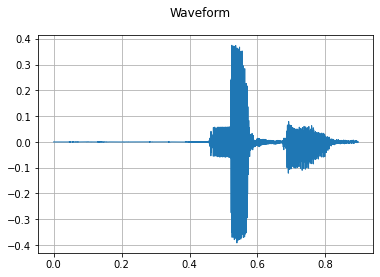

In [6]:
waveform, sample_rate = torchaudio.load(wav_file)
audio_util.plot_waveform(waveform, sample_rate)

In [7]:
waveform.shape

torch.Size([1, 14336])

In [8]:
sample_rate

16000

## 任选一档案测试，发音为 happy

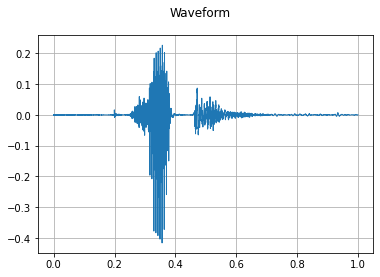

In [9]:
wav_file = train_audio_path+'happy/0b09edd3_nohash_0.wav'

# 播放语音
display(Audio(wav_file, autoplay=False))

# 绘制波形
waveform, sample_rate = torchaudio.load(wav_file)
audio_util.plot_waveform(waveform, sample_rate) 

In [10]:
# 播放音讯
waveform, sample_rate, label, speaker_id, utterance_number = dataset[0]
Audio(waveform, rate=sample_rate)

## 取得音档的属性

In [11]:
info = torchaudio.info(wav_file)
print(f'取样率={info.sample_rate}, 帧数={info.num_frames}, ' +
      f'声道={info.num_channels}, 精度={info.bits_per_sample}, ' +
      f'档案秒数={info.num_frames / info.sample_rate:.2f}')

取样率=16000, 帧数=16000, 声道=1, 精度=16, 档案秒数=1.00


## 重抽样

In [12]:
# 载入音档
waveform, sample_rate = torchaudio.load(wav_file)

# 重抽样率，每秒取 8000 个样本
resample_rate = 8000
resampled_waveform = torchaudio.functional.resample(
                        waveform, sample_rate, resample_rate)
print(f'帧数={resampled_waveform.shape[1]}')

帧数=8000


In [13]:
type(waveform)

torch.Tensor

## 取得所有子目录名称，当作标记。

In [14]:
labels=os.listdir(train_audio_path)
labels

['bed', 'cat', 'happy']

## 统计各类别的档案数

档案数=[2014, 2031, 2054]


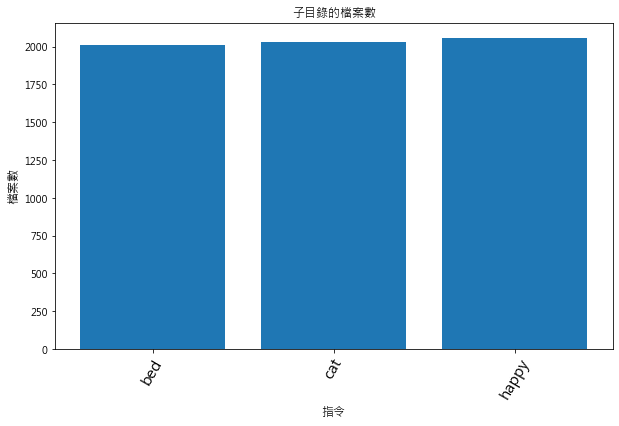

In [15]:
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) 
             if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
# 绘图
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,6))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('指令', fontsize=12)
plt.ylabel('档案数', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('子目录的档案数')
print(f'档案数={no_of_recordings}')
plt.show()

## 音档长度统计

<AxesSubplot:ylabel='Count'>

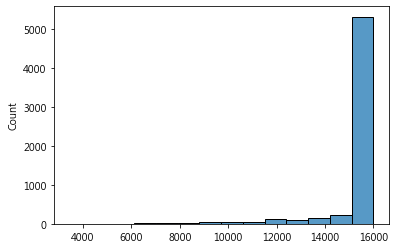

In [16]:
import seaborn as sns
length_list=[]
for x in dataset:
    waveform, sample_rate, label, speaker_id, utterance_number = x
    length_list.append(waveform.shape[1])
sns.histplot(length_list)

## 步骤1：下载资料集，并建立 Dataset

In [17]:
dataset = torchaudio.datasets.SPEECHCOMMANDS('./audio', download=True)

## 设定参数

In [18]:
BATCH_SIZE = 100  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 步骤2：资料清理，此步骤无需进行

## 步骤3：特征工程：音讯转换为MFCC

In [19]:
TOTAL_FRAME_COUNT = 16000  # 统一帧数为 16000 
n_mfcc = 40  # 萃取 MFCC 个数

class SPEECH_DS(Dataset):
    def __init__(self, dataset1):
        self.dataset1 = dataset1
        
    def __len__(self):
          return len(self.dataset1)  

    def __getitem__(self, n):
        waveform , sample_rate, label, _, _ = self.dataset1[n]
        if waveform.shape[1] < TOTAL_FRAME_COUNT : # 长度不足，右边补 0 
            waveform = F.pad(waveform,
                     (0, TOTAL_FRAME_COUNT-waveform.shape[1]),'constant')
        elif waveform.shape[1] > TOTAL_FRAME_COUNT : # 长度过长则截断
            waveform = waveform[:, :TOTAL_FRAME_COUNT]
        if waveform.shape[1] != TOTAL_FRAME_COUNT:  # 确认帧数为 16000
            print(waveform.shape[1])
        
        mfcc_transform = T.MFCC(
            sample_rate=sample_rate,
            n_mfcc=n_mfcc,   
        )
        mfcc = mfcc_transform(waveform)
        # print(mfcc)
        return mfcc, labels.index(label)
    
dataset_new = SPEECH_DS(dataset)

In [20]:
dataset_new[0][0].shape

torch.Size([1, 40, 81])

In [21]:
dataset_new[0][0]

tensor([[[-5.8040e+02, -5.7552e+02, -5.7766e+02,  ..., -5.5747e+02,
          -5.6225e+02, -5.6538e+02],
         [ 5.2286e+00,  1.6873e+01,  1.8741e+01,  ...,  1.6690e+01,
           1.1457e+01,  2.0893e+01],
         [-4.3655e+00,  3.9004e+00,  3.8805e+00,  ...,  9.1251e+00,
          -1.7784e+00,  1.0627e+01],
         ...,
         [ 8.0960e+00, -2.7053e+00, -3.0202e+00,  ..., -5.0008e+00,
          -3.5156e+00, -4.3835e+00],
         [ 7.1246e-01,  1.2997e+00, -4.7095e+00,  ...,  5.2304e+00,
          -3.8770e-01,  2.3371e+00],
         [-3.9061e+00, -1.4976e+00, -3.0793e+00,  ..., -2.9170e+00,
           2.0787e+00,  7.2918e+00]]])

## 步骤4：资料分割

In [22]:
from torch.utils.data import random_split

test_size = int(len(dataset_new) * 0.2)
train_size = len(dataset_new) - test_size

train_ds, test_ds = random_split(dataset_new, [train_size, test_size])
len(train_ds), len(test_ds)

(4880, 1219)

## 建立 DataLoader

In [23]:
train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, BATCH_SIZE*2, shuffle=False)

## 步骤5：建立模型结构

In [24]:
Linear_Input = 6400
class ConvNet(nn.Module):
    def __init__(self, num_classes=3):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            # Conv2d 参数： in-channel, out-channel, kernel size, Stride, Padding
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(Linear_Input, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = F.log_softmax(out, dim=1)
        return out

model = ConvNet(num_classes=3).to(device)

## 定义评分的函数

In [25]:
def score_model():
    model.eval()
    test_loss = 0
    correct = 0
    prediction_list = []
    target_list = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # 预测
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target).item()            

            # 计算正确数
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()
            prediction_list.extend(predicted.cpu().numpy())
            target_list.extend(target.cpu().numpy())

    # 平均损失
    test_loss /= len(test_loader.dataset) 
    # 显示测试结果
    batch = batch_idx * len(data)
    data_count = len(test_loader.dataset)
    percentage = 100. * correct / data_count 
    print(f'平均损失: {test_loss:.4f}, 准确率: {correct}/{data_count}' + 
          f' ({percentage:.2f}%)\n')
    return prediction_list, target_list

In [26]:
epochs = 10

# 设定优化器(optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# 每 20 执行周期，学习率降低 10%
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  

model.train()
loss_list = []    
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        # if batch_idx == 0 : print(output, target)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx+1) % 10 == 0:
            loss_list.append(loss.item())
            batch = (batch_idx+1) * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * (batch_idx+1) / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')
    score_model()
    scheduler.step()

Epoch 1: [ 1000 / 4880] (20 %)  Loss: 1.211543
Epoch 1: [ 2000 / 4880] (41 %)  Loss: 1.180565
Epoch 1: [ 3000 / 4880] (61 %)  Loss: 0.826242
Epoch 1: [ 4000 / 4880] (82 %)  Loss: 0.716565
平均损失: 0.0035, 准确率: 923/1219 (75.72%)

Epoch 2: [ 1000 / 4880] (20 %)  Loss: 0.471511
Epoch 2: [ 2000 / 4880] (41 %)  Loss: 0.601954
Epoch 2: [ 3000 / 4880] (61 %)  Loss: 0.487763
Epoch 2: [ 4000 / 4880] (82 %)  Loss: 0.510090
平均损失: 0.0025, 准确率: 1032/1219 (84.66%)

Epoch 3: [ 1000 / 4880] (20 %)  Loss: 0.339574
Epoch 3: [ 2000 / 4880] (41 %)  Loss: 0.407503
Epoch 3: [ 3000 / 4880] (61 %)  Loss: 0.390502
Epoch 3: [ 4000 / 4880] (82 %)  Loss: 0.410495
平均损失: 0.0022, 准确率: 1064/1219 (87.28%)

Epoch 4: [ 1000 / 4880] (20 %)  Loss: 0.272166
Epoch 4: [ 2000 / 4880] (41 %)  Loss: 0.325730
Epoch 4: [ 3000 / 4880] (61 %)  Loss: 0.323772
Epoch 4: [ 4000 / 4880] (82 %)  Loss: 0.321853
平均损失: 0.0020, 准确率: 1082/1219 (88.76%)

Epoch 5: [ 1000 / 4880] (20 %)  Loss: 0.231158
Epoch 5: [ 2000 / 4880] (41 %)  Loss: 0.281258

In [27]:
score_model();

平均损失: 0.0015, 准确率: 1130/1219 (92.70%)



## 对训练过程的损失绘图

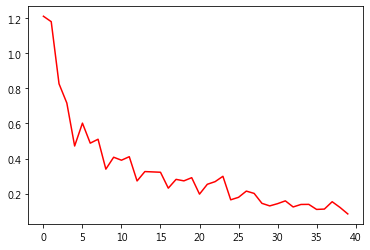

In [28]:
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

## 步骤9：模型布署

In [29]:
# 模型存档
torch.save(model, 'Speech_Command.pth')
# 模型载入
model = torch.load('Speech_Command.pth')

## 步骤10：预测

In [30]:
# 预测函数
def predict(wav_file):
    waveform , sample_rate = torchaudio.load(wav_file)
    
    if waveform.shape[1] < TOTAL_FRAME_COUNT: # 长度不足，右边补 0
        waveform = F.pad(waveform,(0, 
                   TOTAL_FRAME_COUNT-waveform.shape[1]),'constant')
    elif waveform.shape[1] > TOTAL_FRAME_COUNT: # 长度过长则截断
        waveform = waveform[:, :TOTAL_FRAME_COUNT]
    if waveform.shape[1] != TOTAL_FRAME_COUNT:
        print(waveform.shape[1])

    mfcc_transform = T.MFCC(
        sample_rate=sample_rate,
        n_mfcc=n_mfcc,   # MFCC 个数
    )
    mfcc = mfcc_transform(waveform)
    mfcc = mfcc.reshape(1,*mfcc.shape)
    # print(mfcc)
    
    #print(X_pred.shape, samples.shape)
    # 预测
    output = model(mfcc.to(device))
    _, predicted = torch.max(output.data, 1)
    return predicted.cpu().item()

## 任选一档案测试，该档案发音为 bed

In [31]:
predict(train_audio_path+'bed/0d2bcf9d_nohash_0.wav')

0

## 任选一档案测试，该档案发音为 cat

In [32]:
predict(train_audio_path+'cat/0ac15fe9_nohash_0.wav')

1

## 任选一档案测试，该档案发音为 happy

In [33]:
predict(train_audio_path+'happy/0ab3b47d_nohash_0.wav')

2

## 自行使用 14_10_record.py 录音，指令：
#### python 14_13_record.py audio/happy.wav

## 测试，该档案发音为 bed

In [44]:
predict('./audio/bed.wav')

0

## 测试，该档案发音为 cat

In [47]:
predict('./audio/cat.wav')

1

## 测试，该档案发音为 happy

In [46]:
predict('./audio/happy.wav')

2